In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

sys.path.insert(0, "/Users/chutianwang/OneDrive/College 2025/Phys_20CL")
from utils import *

# Some Re:0 colors, color blind proof.
# It works with gray scale, too.
# Also pretty cute :P
colors = [
    (143/255,  78/255, 180/255),#purple
    ( 71/255, 142/255, 219/255),#blue
    (208/255, 134/255, 188/255),#pink
    (218/255, 165/255,  93/255),#orange
]

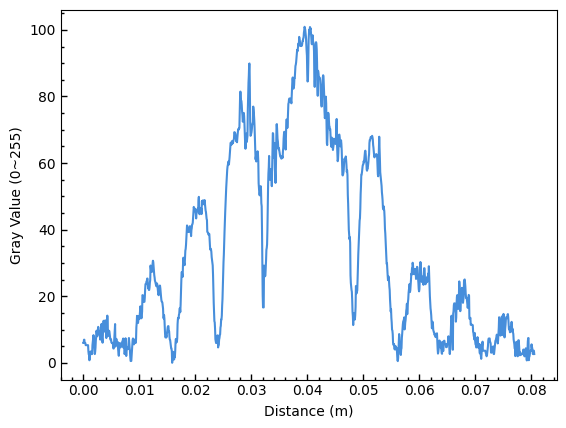

In [2]:
fig, ax = plt.subplots()
demo = CSVexplorer("single0.08mm.csv")
demo.convertType((0,1), float)
setAx(ax)
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Gray Value (0~255)")
ax.plot(demo["Distance_(m)"], demo["Gray_Value"],
        color = colors[1],
        label = "Intensity of light")


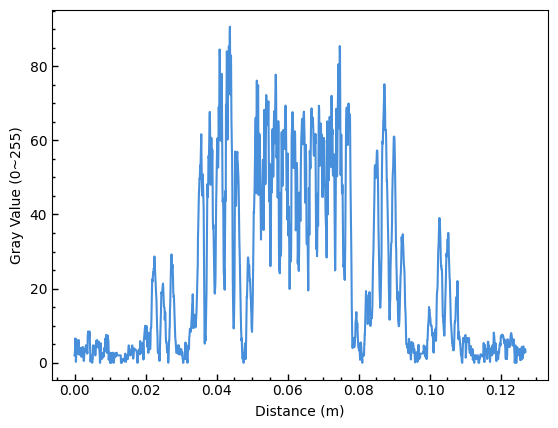

In [3]:
fig, bx = plt.subplots()
demo = CSVexplorer("0.04,0.25.csv")
demo.convertType((0,1), float)
setAx(bx)
bx.set_xlabel("Distance (m)")
bx.set_ylabel("Gray Value (0~255)")
bx.plot(demo["Distance_(m)"], demo["Gray_Value"],
        color = colors[1],
        label = "Intensity of light")

In [4]:
class Experiment():
    def __init__(self, name: str):
        self.name = name
        self.a = 0
        self.d = 0
        self.L = 1
        self.ndiff = np.array([-2,-1,0,1,2])
        self.zdiff = np.zeros((5,2))
        
        self.ndiffmin = np.array([-2, -1, 1, 2])
        self.zdiffmin = np.zeros((2,4))
        
        self.nint = np.array([-2,-1,0,1,2])
        self.zint = np.zeros((5,2))
        
        self.lbdModel = lambda n, lbd: n * lbd * self.L / self.a
        self.lbd = 0
        self.dlbd = 0
        self.lbdChi2 = 0
        
    def lambdaStats(self):
        v, cov = curve_fit(self.lbdModel, self.ndiffmin, self.zdiffmin[0])
        self.lbd = v[0]
        self.dlbd = cov[0][0]
        self.lbdChi2 = chisq(self.lbdModel(self.ndiffmin, self.lbd), self.zdiffmin[0], self.zdiffmin[1])
        self.plbdChi2 = chi2.cdf(self.lbdChi2, self.ndiffmin.size - v.size)
        return {
                "name": self.name,
                "lambda": self.lbd,
                "delta lambda": self.dlbd,
                "Chi2": self.lbdChi2,
                "p": self.plbdChi2
               }
        
    def intChi2(self):
        chi2Val = chisq(self.zint[0], self.nint * self.lbd * self.L / self.d * 1000, self.zint[1])
        chi2P = chi2.cdf(chi2Val, self.nint.size - 1)
        return {
            "Chi2": chi2Val,
            "p": chi2P
        }
    
    def plot(self, nx, which = "diff", lambdaEst = 600, color = 0):
        self.lambdaStats()
        setAx(nx)
        nx.set_xlabel('n')
        nx.set_ylabel("z (mm)")
        if which == "diff":
            nx.errorbar(
                self.ndiffmin, self.zdiffmin[0] * 1000, yerr = self.zdiffmin[1] * 1000,
                fmt = 'o', capsize = 3, color = colors[color],
                label = self.name + fr", fitted $\lambda={{{self.lbd * 1e9 :.0f}}}$ nm"
            )
            nx.plot(self.ndiffmin, self.lbdModel(self.ndiffmin, self.lbd) * 1000,
                   color = colors[color])
        else:
            chi2_ = self.intChi2()
            chi2Val = chi2_["Chi2"]
            chi2p = chi2_["p"]
            nx.errorbar(
                self.nint, self.zint[0] * 1000, yerr = self.zint[1] * 1000,
                fmt = 'o', capsize = 3, color = colors[color],
                label = self.name
            )
            nx.plot(self.nint, self.nint * lambdaEst * 1e-9 * self.L / self.d * 1000,
                   color = colors[color])
        nx.legend()

In [5]:
data = CSVexplorer("data.csv", ignoreRow = 1)

S0 = Experiment(r"single slit, $a=0.02$ mm")
S1 = Experiment(r"single slit, $a=0.04$ mm")
S2 = Experiment(r"single slit, $a=0.08$ mm")
S3 = Experiment(r"single slit, $a=0.016$ mm")
L1 = Experiment(r"single slit, $a=0.08$ mm, $L=0.8$ m")
L2 = Experiment(r"single slit, $a=0.08$ mm, $L=0.6$ m")
L3 = Experiment(r"single slit, $a=0.08$ mm, $L=0.4$ m")
D0 = Experiment(r"$a=0.04$ mm, $d=0.25$ mm")
D1 = Experiment(r"$a=0.04$ mm, $d=0.50$ mm")
D2 = Experiment(r"$a=0.08$ mm, $d=0.25$ mm")
D3 = Experiment(r"$a=0.08$ mm, $d=0.50$ mm")

singleGroups = [S0, S1, S2, S3, L1, L2, L3]
doubleGroups = [D0, D1, D2, D3]
allGroups = singleGroups + doubleGroups

for idx, group in enumerate(singleGroups):
    group.a = float(data["\ufeffadvertised a"][idx])
    group.L = float(data["L"][idx])
    if idx == 0: continue
    else:
        for n in group.ndiff:
            group.zdiff[n+2][0] = float(data[f"y_diff(n={n:.0f})"][idx].split("±")[0])
            group.zdiff[n+2][1] = float(data[f"y_diff(n={n:.0f})"][idx].split("±")[1])

for idx, group in enumerate(doubleGroups):
    group.a = float(data["\ufeffadvertised a"][idx+7]) / 1000
    group.d = float(data["advertised d"][idx+7]) / 1000
    group.L = float(data["L"][idx+7]) / 1000
    
    for n in group.nint:
        group.zint[n+2][0] = float(data[f"y_int(n={n:.0f})"][idx+7].split("±")[0])
        group.zint[n+2][1] = float(data[f"y_int(n={n:.0f})"][idx+7].split("±")[1])

    for n in group.ndiff:
        group.zdiff[n+2][0] = float(data[f"y_diff(n={n:.0f})"][idx+7].split("±")[0])
        group.zdiff[n+2][1] = float(data[f"y_diff(n={n:.0f})"][idx+7].split("±")[1])

for group in allGroups:
    group.zdiff = np.swapaxes(group.zdiff, 0, 1)
    group.zdiff[0] = group.zdiff[0] - group.zdiff[0][2]
    for i in range(0,4):
        group.zdiffmin[0][i] = (group.zdiff[0][i] + group.zdiff[0][i+1]) / 2
        group.zdiffmin[1][i] = (group.zdiff[1][i] + group.zdiff[1][i+1]) / 2
    group.zint = np.swapaxes(group.zint, 0, 1)
    group.zint[0] = group.zint[0] - group.zint[0][2]

{'name': 'single slit, $a=0.04$ mm', 'lambda': 5.812399999999854e-07, 'delta lambda': 1.4703914469618574e-15, 'Chi2': 713.9320086456928, 'p': 1.0}
{'name': 'single slit, $a=0.08$ mm', 'lambda': 5.898000000000034e-07, 'delta lambda': 1.5535760048872351e-15, 'Chi2': 436.607667245271, 'p': 1.0}
{'name': 'single slit, $a=0.016$ mm', 'lambda': 6.00720000000005e-07, 'delta lambda': 1.4943125402476232e-15, 'Chi2': 325.9850248622644, 'p': 1.0}
{'name': 'single slit, $a=0.08$ mm, $L=0.8$ m', 'lambda': 5.929999999999906e-07, 'delta lambda': 1.3950833213246593e-15, 'Chi2': 442.7166713209737, 'p': 1.0}
{'name': 'single slit, $a=0.08$ mm, $L=0.6$ m', 'lambda': 5.750666666666895e-07, 'delta lambda': 1.7749689260179182e-15, 'Chi2': 458.8148859503192, 'p': 1.0}
{'name': 'single slit, $a=0.08$ mm, $L=0.4$ m', 'lambda': 5.579999999999846e-07, 'delta lambda': 1.8061666412855653e-15, 'Chi2': 46.63288596783656, 'p': 0.9999999995839801}
{'name': 'single slit, $a=0.08$ mm', 'lambda': 5.898000000000034e-07, '

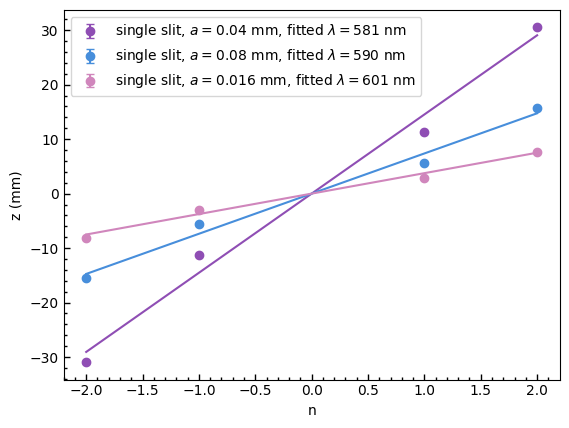

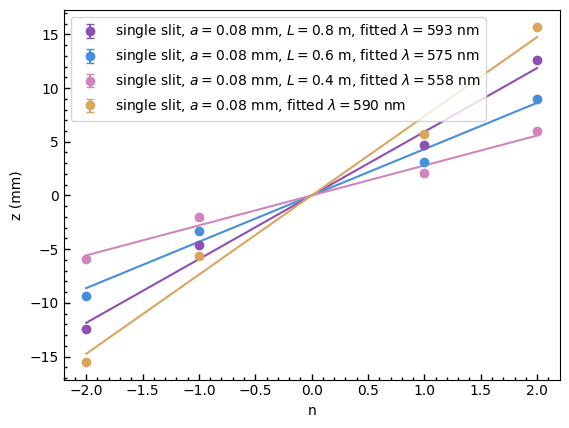

In [6]:
fig, ax = plt.subplots()
for idx, group in enumerate(singleGroups[1:4]):
    print(group.lambdaStats())
    group.plot(ax, color = idx)

fig, bx = plt.subplots()
for idx, group in enumerate(singleGroups[4:7] + [S2]):
    print(group.lambdaStats())
    group.plot(bx, color = idx)

In [7]:
lbd = np.array([group.lbd for group in singleGroups[1:]])
print(lbd.mean())
print(RMSD(lbd))

5.829711111111098e-07
1.3852008099735716e-08


{'Chi2': 1729.4999999999995, 'p': 1.0}
{'Chi2': 423.49999999999983, 'p': 1.0}
{'Chi2': 1626.499999999999, 'p': 1.0}
{'Chi2': 412.7499999999999, 'p': 1.0}


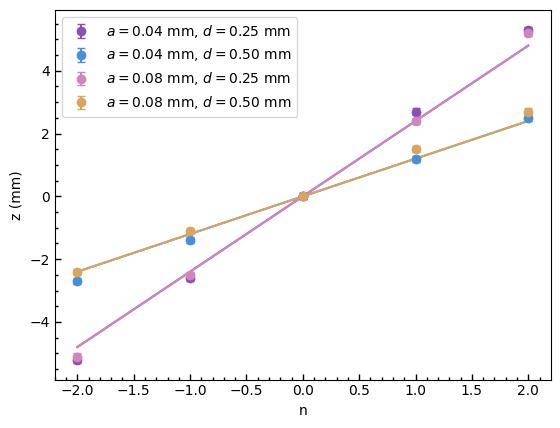

In [8]:
fig, cx = plt.subplots()
for idx, group in enumerate(doubleGroups):
    print(group.intChi2())
    group.plot(cx, which = "int", color = idx)
